# Regressão Linear - Transformação de Variáveis + Variáveis Dummy

 Legendas:
   * <code style="color:green">Explicação Conteúdo</code>
   * <code style="color:purple">Dicas / Comandos / Comentários</code>
   * <code style="color:red">Prática</code>



In [35]:
import pandas as pd # importando a biblioteca de manipulação de dados
import statsmodels.api as sm # biblioteca para a regressão logística
import numpy as np # biblioteca para calculo
from matplotlib import pyplot as plt # importando a biblioteca de visualização de dados 
import seaborn as sns# importando a biblioteca de visualização de dados 
from sklearn.metrics import mean_squared_error
import scipy.stats as stats # biblioteca para análise estatistica
from statsmodels.stats.diagnostic import het_breuschpagan # função para o teste de breusch-pagan
import pyreadr # biblioteca para leitura de dados R
import numpy as np # biblioteca para calculo numérico

### <code style="color:green">DISCUSSÃO:</code>

No python, utilizando as bibliotecas mais conhecidas, não encontramos os métodos de seleção backward, forward e setpwise. Logo, a solução para quando se quer utilizá-los é criar alguma função que o faça. 

Sendo assim, criamos algumas funções que serão utilizadas em aula para seleção de variáveis. Elas serão carregadas todas de uma única vez:

In [36]:
from selecao_variaveis_regressao_linear import step

### <code style="color:green">Vamos começar:</code>

O propósito aqui é utilizar a base preços, selecionar apenas as variáveis numéricas e tentar aplicar alguma transformação a fim de verificar se o modelo melhora (não quer dizer que vai melhorar).

In [37]:
# fazendo a leitura do arquivo já em R (caso não tenha essa biblioteca, não deixe de instalar)
precos = pyreadr.read_r('dados/precos.rds')[None]
precos.head()

,SalePrice,Basement_Area,Lot_Area,Heating_QC,Season_Sold,Gr_Liv_Area,Garage_Area,Deck_Porch_Area,Age_Sold,Bedroom_AbvGr,Total_Bathroom
0,215000.0,1080.0,31770.0,Fa,2.0,1656.0,528.0,272.0,50.0,3.0,2.0
1,105000.0,882.0,11622.0,TA,3.0,896.0,730.0,260.0,49.0,2.0,1.0
2,172000.0,1329.0,14267.0,TA,3.0,1329.0,312.0,429.0,52.0,3.0,1.1
3,244000.0,2110.0,11160.0,Ex,2.0,2110.0,522.0,0.0,42.0,3.0,3.1
4,189900.0,928.0,13830.0,Gd,2.0,1629.0,482.0,246.0,13.0,3.0,2.1


In [38]:
# selecionando apenas as variaveis numericas para brincar
precos = precos.drop(['Heating_QC','Season_Sold'],axis = 1)

Seria interessante se você tentasse fazer o modelo onde y=SalePrice e as variáveis X sendo as demais variáveis numéricas.
Eu já sei que, infelizmente, o modelo não passaá na análise de resíduo e por isso focarei na estratégia de transformar as variáveis X´s.

### <code style="color:green">Transformando as Variáveis X´s</code>

- Quando temos as variáveis independentes muito assimétricas, uma boa estratégia é realizar a transformação em LOG delas!

- Assim elas podem ajudar não só no desempenho do modelo, mas também ajudam a normalizar os resíduos

In [39]:
# primeiro vou aplicar o log de todas as variaveis X´s
precos_log = precos.copy()
precos_log['Basement_Area_log'] = np.log10(precos_log['Basement_Area'] + 1)
precos_log['Lot_Area_log'] = np.log10(precos_log['Lot_Area'] + 1)
precos_log['Gr_Liv_Area_log'] = np.log10(precos_log['Gr_Liv_Area'] + 1)
precos_log['Garage_Area_log'] = np.log10(precos_log['Garage_Area'] + 1)
precos_log['Deck_Porch_Area_log'] = np.log10(precos_log['Deck_Porch_Area'] + 1)
precos_log['Age_Sold_log'] = np.log10(precos_log['Age_Sold'] + 2)
precos_log['Bedroom_AbvGr_log'] = np.log10(precos_log['Bedroom_AbvGr'] + 1)
precos_log['Total_Bathroom_log'] = np.log10(precos_log['Total_Bathroom'] + 1)

### <code style="color:purple">DICAS:</code>

* Adicionar 1 no log de cada uma das variáveis evita o erro de log(0), pois é provável que algum valor nas colunas seja 0, e como log(0) não é definido, fazemos essa correção.

C:\Users\mattr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\mattr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
C:\Users\mattr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
C:\Users\mattr\AppData\Local\Package

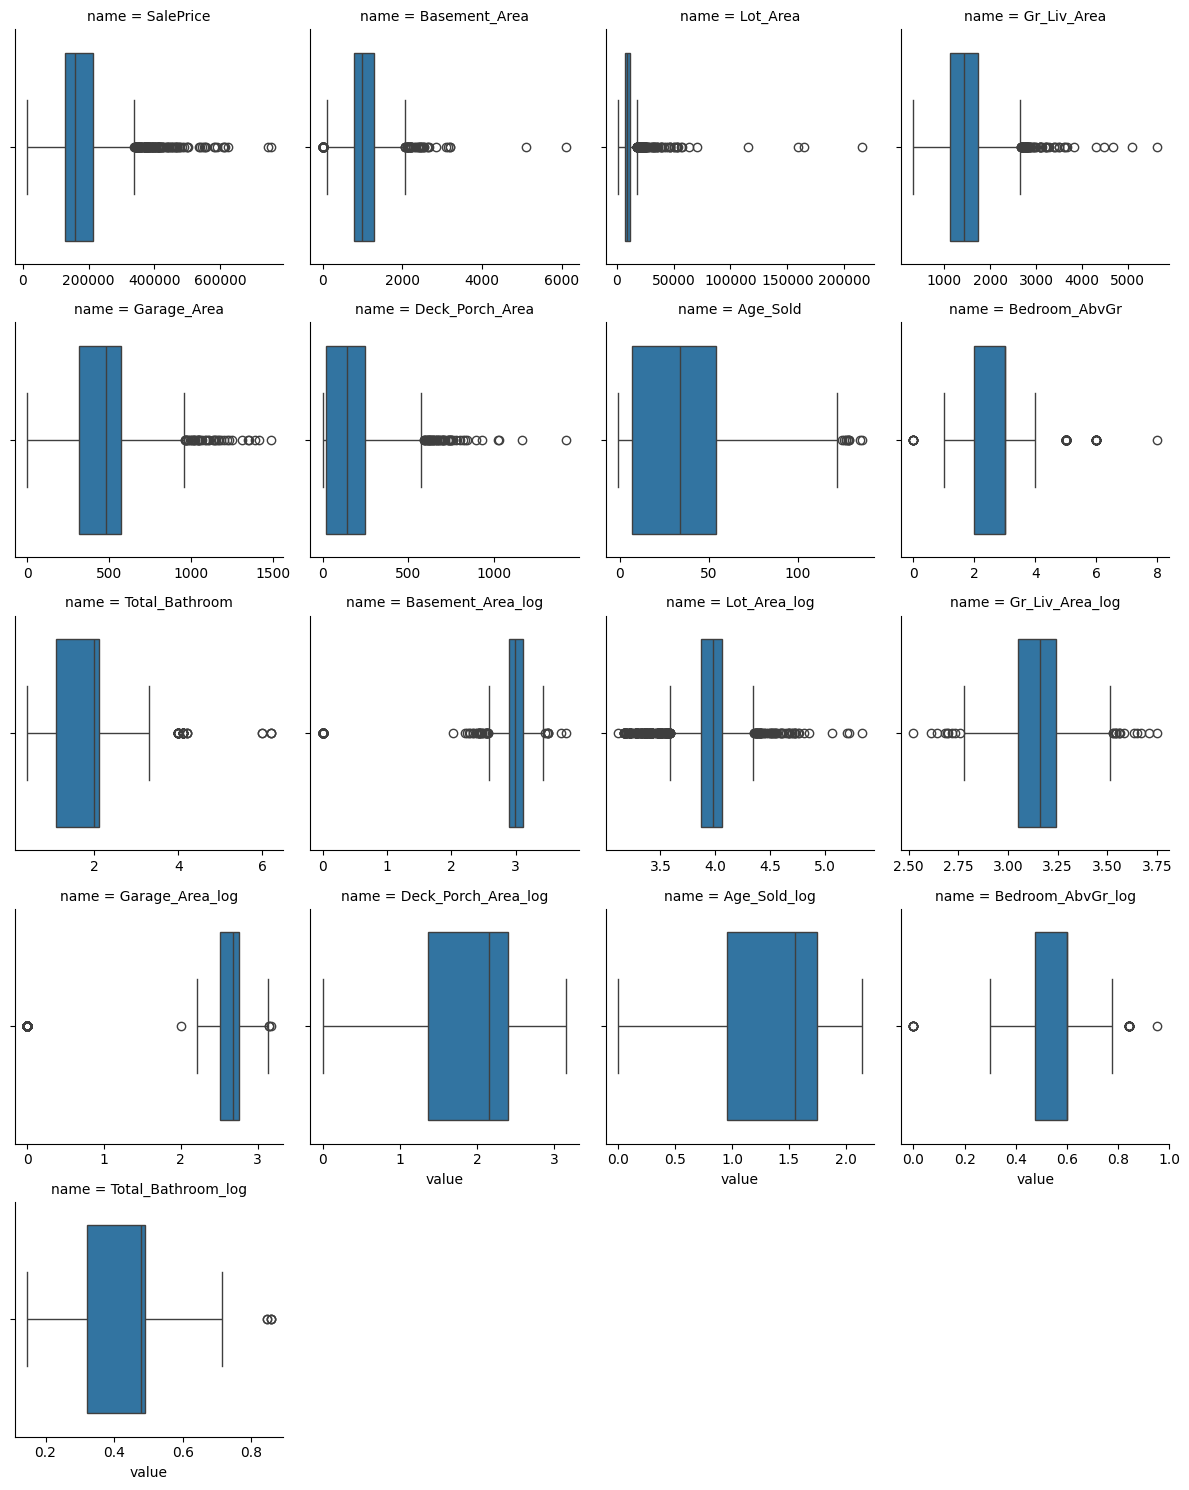

In [40]:
# transoformacao para long com o objetivo de criar vários gráficos de boxplot
precos_long = precos_log.melt(var_name='name', value_name='value') 
#criando a grade
g = sns.FacetGrid(precos_long, col='name', col_wrap=4, sharex=False, sharey=False) 
# boxplot para cada variavel
g.map(sns.boxplot, 'value', orient='h') 

# Ajustar o layout
plt.tight_layout()
plt.show()

### <code style="color:purple">COMENTÁRIOS:</code>

- Note que quase todas as variáveis são bem assimétricas.
- Após a transformação podemos ver uma suavização dessa assimetria.
- Agora é testar:

### <code style="color:green">Fazendo o Modelo Utilizando Todas as Variáveis</code>

- Vamos analisar o comportamento do modelo com todas as variáveis 

- Além disso, vamos selecionar as melhores variáveis usando o método StepWise com o AIC e P-valor


In [41]:
# Criando o objeto X com a variável independentes. 
# Utilizei o comando like para pegar apenas as variáveis que tenham _log em seu nome
X = precos_log.filter(like='_log')
# criando o objeto y com a variável resposta
y = precos_log["SalePrice"]
# Aqui lembre-se do B0. Basicamente vamos adicionar uma coluna de 1s para que o B0 seja calculado.
X = sm.add_constant(X)
# Ajustando o modelo
model_preco_log_completo = sm.OLS(y, X).fit()
# Resumo do modelo
print(model_preco_log_completo.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     949.0
Date:                Tue, 21 Jan 2025   Prob (F-statistic):               0.00
Time:                        13:42:08   Log-Likelihood:                -35331.
No. Observations:                2928   AIC:                         7.068e+04
Df Residuals:                    2919   BIC:                         7.073e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -9.166e+05   2

In [42]:
# regressão por stepwise usando AIC
# Utilizei o comando like para pegar apenas as variáveis que tenham _log em seu nome
X = precos_log.filter(like='_log')
# criando o objeto y com a variável resposta
y = precos_log["SalePrice"]
# regressao por stepwise usando AIC
colunas_step_AIC = step(var_dependente = 'SalePrice', var_independente = X.columns.to_list(), base = precos_log, metodo = 'both' ,metrica = 'aic')
# colocando em uma lista o nome de todas as variaveis do modelo com menor aic
X_step_AIC = precos_log [ colunas_step_AIC['var'].to_list()[0] ]
# Aqui lembre-se do B0. Basicamente vamos adicionar uma coluna de 1s para que o B0 seja calculado.
X_step_AIC = sm.add_constant(X_step_AIC)
# Ajustando o modelo
model_preco_log_step_AIC = sm.OLS(y, X_step_AIC).fit()
# Resumo do modelo
print(model_preco_log_step_AIC.summary()) 
# gerando a predição através desse modelo
pred_aic = model_preco_log_step_AIC.predict(X_step_AIC)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     949.0
Date:                Tue, 21 Jan 2025   Prob (F-statistic):               0.00
Time:                        13:42:09   Log-Likelihood:                -35331.
No. Observations:                2928   AIC:                         7.068e+04
Df Residuals:                    2919   BIC:                         7.073e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -9.166e+05   2

In [43]:
# regressão por stepwise usando p-valor
# Utilizei o comando like para pegar apenas as variáveis que tenham _log em seu nome
X = precos_log.filter(like='_log')
# criando o objeto y com a variável resposta
y = precos_log["SalePrice"]
# regressão por stepwise usando p-valor
colunas_step_pvalor = step(var_dependente = 'SalePrice', var_independente = X.columns.to_list(), base = precos_log, metodo = 'both' ,metrica = 'pvalor')
# colocando em uma lista o nome de todas as variaveis do modelo por p-valor
X_step_pvalor = precos_log [ colunas_step_pvalor['var'] ]
# Aqui lembre-se do B0. Basicamente vamos adicionar uma coluna de 1s para que o B0 seja calculado.
X_step_pvalor = sm.add_constant(X_step_pvalor)
# Ajustando o modelo
model_preco_log_step_pvalor = sm.OLS(y, X_step_pvalor).fit()
# Resumo do modelo
print(model_preco_log_step_pvalor.summary()) 
# gerando a predição através desse modelo
pred_pvalor = model_preco_log_step_pvalor.predict(X_step_pvalor)

C:\Users\mattr\Documents\trabalho\validacao_aulas\regressao_modulo\selecao_variaveis_regressao_linear.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pvalor = modelo.pvalues[1]
C:\Users\mattr\Documents\trabalho\validacao_aulas\regressao_modulo\selecao_variaveis_regressao_linear.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pvalor = modelo.pvalues[1]
C:\Users\mattr\Documents\trabalho\validacao_aulas\regressao_modulo\selecao_variaveis_regressao_linear.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     949.0
Date:                Tue, 21 Jan 2025   Prob (F-statistic):               0.00
Time:                        13:42:09   Log-Likelihood:                -35331.
No. Observations:                2928   AIC:                         7.068e+04
Df Residuals:                    2919   BIC:                         7.073e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -9.166e+05   2

C:\Users\mattr\Documents\trabalho\validacao_aulas\regressao_modulo\selecao_variaveis_regressao_linear.py:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pvalor = modelo.pvalues.drop(preditoras)[1]
C:\Users\mattr\Documents\trabalho\validacao_aulas\regressao_modulo\selecao_variaveis_regressao_linear.py:231: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(pvalor_geral[ np.argmax(pvalor_geral) ] > signif ):


### <code style="color:green">Fazendo Análise de Resíduo do Modelo</code>

- Vamos analisar os resíduos do StepWise com o P-Valor

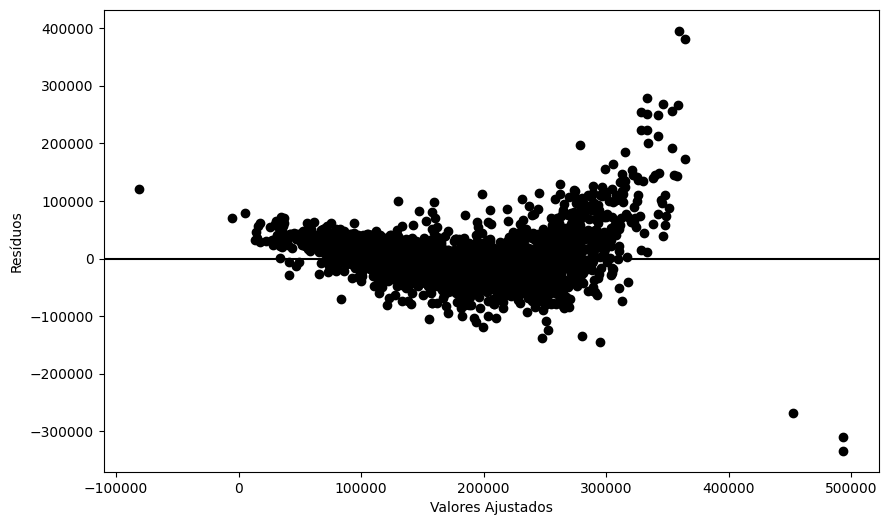

In [44]:
# plotando o ajustado X residuo 
plt.figure(figsize=(10, 6))

plt.scatter(pred_pvalor,model_preco_log_step_pvalor.resid, color='black')
plt.axhline(y=0, color = 'black')
plt.xlabel('Valores Ajustados')
plt.ylabel('Resíduos')
plt.show()

### <code style="color:purple">COMENTÁRIOS:</code>

- Note que vemos um padrão nos resíduos, o que indica que não são independentes.
- Além disso notamos um movimento de "boca de jacaré", o que pode indicar que as variâncias são heterocedásticas.

### <code style="color:green">Testando a Normalidade dos Resíduos</code>

Normalidade (Shapiro-Wilk):

- $H_{0}:$ Os resíduos são normais
- $H_{1}:$ Os resíduos não são normais


ShapiroResult(statistic=0.8797729015350342, pvalue=6.670180690186129e-43)


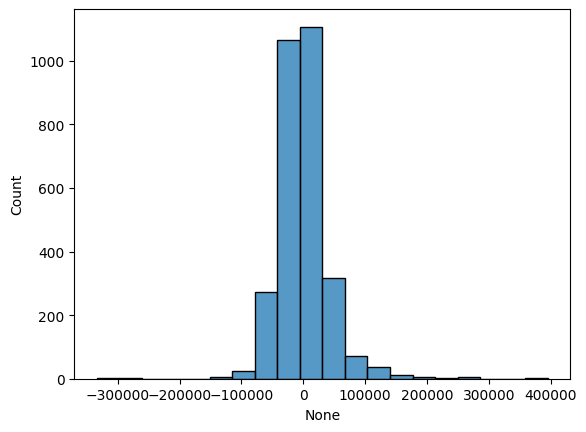

In [45]:
# teste de normalidade
print(stats.shapiro(model_preco_log_step_pvalor.resid))
sns.histplot(x=model_preco_log_step_pvalor.resid, bins=20)
plt.show()

### <code style="color:green">Fazendo o Teste de Homogeneidade de Variância</code>

Validando o pressuposto de Homogeneidade de Variâncias através do teste de Breusch-Pagan:

- $H_{0}:$ Os resíduos possuem homogeneidade nas variâncias
- $H_{1}:$ Os resíduos não possuem homogeneidade nas variâncias

In [46]:
# Realizando o teste de Breusch-Pagan para verificar heterocedasticidade
# Passamos os resíduos do modelo (stepw_p.resid) e as variáveis explicativas (stepw_p.model.exog)
teste_bp = het_breuschpagan(model_preco_log_step_pvalor.resid, model_preco_log_step_pvalor.model.exog)
# Definindo os rótulos para os resultados do teste
rotulos = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
# Usando zip para associar cada rótulo ao seu respectivo resultado do teste e convertendo em um dicionário
resultado_bp = dict(zip(rotulos, teste_bp))
# Exibindo o p-valor do LM-Test
print(resultado_bp['LM-Test p-value'])

2.455723823473312e-74


### <code style="color:purple">COMENTÁRIOS:</code>

- Lascou!! Os resíduos continuam sendo não normais! (pelo teste, porque pelo histograma eu diria que são normais)
- Os resíduos não possuem homogeneidade nas variâncias

- Continuamos sem modelo!


### <code style="color:green">Vamos conversar sobre variáveis categóricas</code>

- Meu objetivo agora é mostrar como trabalhar com variável categórica.

- Vou importar a base novamente e focar apenas a variável Heating_QC. 

- Feito isso vamos realizar o processo de Dummy, que consiste em criar $n-1$ colunas binárias onde cada coluna representa a categoria associada. Retiramos uma categoria do modelo para evitar redundância.

In [47]:
precos1 = pyreadr.read_r('dados/precos.rds')[None]
precos1.head()

,SalePrice,Basement_Area,Lot_Area,Heating_QC,Season_Sold,Gr_Liv_Area,Garage_Area,Deck_Porch_Area,Age_Sold,Bedroom_AbvGr,Total_Bathroom
0,215000.0,1080.0,31770.0,Fa,2.0,1656.0,528.0,272.0,50.0,3.0,2.0
1,105000.0,882.0,11622.0,TA,3.0,896.0,730.0,260.0,49.0,2.0,1.0
2,172000.0,1329.0,14267.0,TA,3.0,1329.0,312.0,429.0,52.0,3.0,1.1
3,244000.0,2110.0,11160.0,Ex,2.0,2110.0,522.0,0.0,42.0,3.0,3.1
4,189900.0,928.0,13830.0,Gd,2.0,1629.0,482.0,246.0,13.0,3.0,2.1


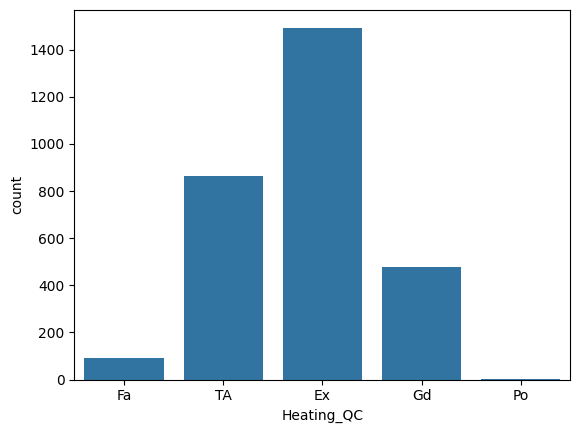

In [48]:
# criando o gráfico de barras, com a frequência de cada categoria
sns.countplot(x='Heating_QC', data=precos1)
plt.show()

### <code style="color:purple">COMENTÁRIOS:</code>

- Já me gerou desconforto porque Po aparece muito pouco

- Vamos fazer um cálculo das médias por Heating_QC e verificar o volume de linha por classe!

In [49]:
precos1.groupby('Heating_QC').agg(
    n = ('Heating_QC','size'),
    mediaSalePrice = ('SalePrice','mean')
)


,n,mediaSalePrice
Heating_QC,,
Ex,1494,216410.411647
Fa,92,122949.597826
Gd,476,156855.056723
Po,3,69033.333333
TA,863,139054.370800


### <code style="color:purple">COMENTÁRIOS:</code>

- A frequência é muito pequena tanto no Po como no Fa

- Eu não me sinto segura, entao vou deixar apenas 3 classes: Ex, TA e Outros (FA + Gd + Po)


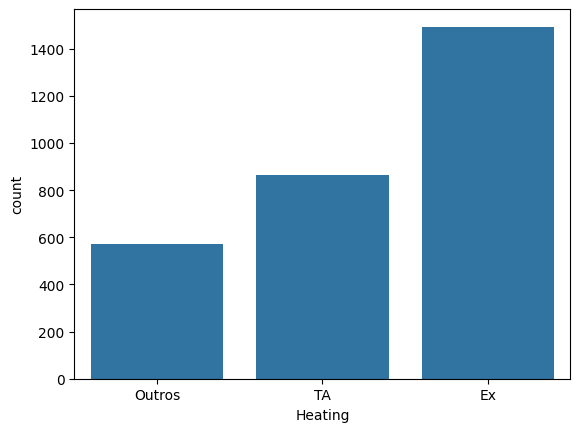

In [50]:
# criando a nova variavel com esse agrupamento
precos1['Heating'] = np.where(precos1['Heating_QC']  == 'Ex', 'Ex',
                                np.where(precos1['Heating_QC']  == 'TA', 'TA', 'Outros')
                                )
# vamos analisar a nova variavel
sns.countplot(x='Heating', data=precos1)
plt.show()

### <code style="color:purple">COMENTÁRIOS:</code>

- O np.where vai percorrer a condição que estabelecemos e substituirá todos que não forem TA e EX por Outros


Vamos analisar os resultados:

In [51]:
precos1.groupby('Heating').agg(
    n = ('Heating','size'),
    mediaSalePrice = ('SalePrice','mean')
)

,n,mediaSalePrice
Heating,,
Ex,1494,216410.411647
Outros,571,150930.770578
TA,863,139054.370800


### <code style="color:green">Criando dummies no python</code>

- Criaremos as variáveis dummy e também o modelo utilizando-as.

In [52]:
precos1_dummie = pd.get_dummies(precos1['Heating']) 
precos1_dummie.head()

,Ex,Outros,TA
0,False,True,False
1,False,False,True
2,False,False,True
3,True,False,False
4,False,True,False


In [53]:
# criando as dummies
precos1_dummie = pd.get_dummies(precos1) 
# quando cria a dummy ele já deleta a original, estou trazendo novamente só para mostrar o que foi feito
precos1_dummie['Heating'] = precos1['Heating'] 
# visualizando os dados
precos1_dummie.head()

,SalePrice,Basement_Area,Lot_Area,Season_Sold,Gr_Liv_Area,Garage_Area,Deck_Porch_Area,Age_Sold,Bedroom_AbvGr,Total_Bathroom,Heating_QC_Ex,Heating_QC_Fa,Heating_QC_Gd,Heating_QC_Po,Heating_QC_TA,Heating_Ex,Heating_Outros,Heating_TA,Heating
0,215000.0,1080.0,31770.0,2.0,1656.0,528.0,272.0,50.0,3.0,2.0,False,True,False,False,False,False,True,False,Outros
1,105000.0,882.0,11622.0,3.0,896.0,730.0,260.0,49.0,2.0,1.0,False,False,False,False,True,False,False,True,TA
2,172000.0,1329.0,14267.0,3.0,1329.0,312.0,429.0,52.0,3.0,1.1,False,False,False,False,True,False,False,True,TA
3,244000.0,2110.0,11160.0,2.0,2110.0,522.0,0.0,42.0,3.0,3.1,True,False,False,False,False,True,False,False,Ex
4,189900.0,928.0,13830.0,2.0,1629.0,482.0,246.0,13.0,3.0,2.1,False,False,True,False,False,False,True,False,Outros


In [54]:
# criando o modelo
# Criando o objeto X com a variável independentes (somente as dummies, já tirando uma delas)
# como as dummies eram booleanas utilizei o astype para transformar em 0 e 1
X = precos1_dummie[['Heating_Ex', 'Heating_TA']].astype(int)
# criando o objeto y com a variável resposta
y = precos1_dummie["SalePrice"]
# Aqui lembre-se do B0. Basicamente vamos adicionar uma coluna de 1s para que o B0 seja calculado.
X = sm.add_constant(X)
# Ajustando o modelo
modelo_dummie = sm.OLS(y, X).fit()
# Resumo do modelo
print(modelo_dummie.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     386.9
Date:                Tue, 21 Jan 2025   Prob (F-statistic):          8.54e-150
Time:                        13:42:10   Log-Likelihood:                -36863.
No. Observations:                2928   AIC:                         7.373e+04
Df Residuals:                    2925   BIC:                         7.375e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.509e+05   2974.121     50.748      0.0

In [55]:
#criando o ychapeu
precos1_dummie['ychapeu_dummie'] = modelo_dummie.predict(X)

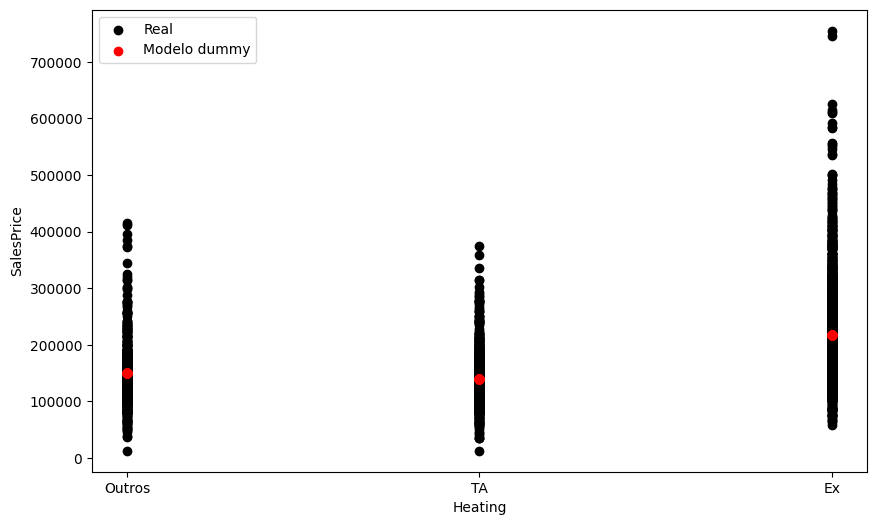

In [56]:
# definindo o tamanho da área do gráfico
plt.figure(figsize=(10, 6))
# adicionando a primeira camada que são nossos dados reais em preto
plt.scatter(precos1_dummie["Heating"], precos1_dummie["SalePrice"], color='black', label='Real')
# adicionando a camada do chute do modelo (média po grupo) em vermelho
plt.scatter(precos1_dummie["Heating"], precos1_dummie["ychapeu_dummie"], color='red', label='Modelo dummy')

plt.xlabel('Heating')
plt.ylabel('SalesPrice')
plt.legend()
plt.show()


### <code style="color:purple">COMENTÁRIOS:</code>

- Note que os chutes nada mais são do que as médias que foram calculadas por categoria pela variável resposta.

### <code style="color:green">Tabalhando Com Uma X Categórica e Outra Numérica</code>

- Agora vamos analisar como a variável categórica se comporta quando temos variáveis numéricas junto.

- Veremos em gráficos sua associação com a variável y e também na modelagem.

- A ideia é saber se essa relação resulta em um bom modelo.


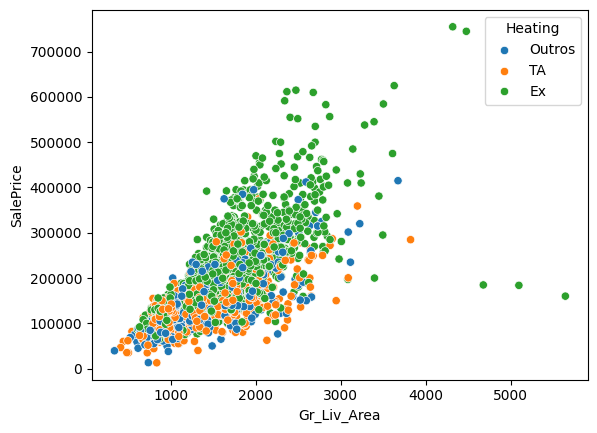

In [57]:
# nesse caso aqui vamos brincar com a Heating e a Gr_Liv_Area
sns.scatterplot(data=precos1_dummie, x='Gr_Liv_Area', y='SalePrice', hue='Heating')
plt.show()

In [58]:
precos1_dummie.head()

,SalePrice,Basement_Area,Lot_Area,Season_Sold,Gr_Liv_Area,Garage_Area,Deck_Porch_Area,Age_Sold,Bedroom_AbvGr,Total_Bathroom,Heating_QC_Ex,Heating_QC_Fa,Heating_QC_Gd,Heating_QC_Po,Heating_QC_TA,Heating_Ex,Heating_Outros,Heating_TA,Heating,ychapeu_dummie
0,215000.0,1080.0,31770.0,2.0,1656.0,528.0,272.0,50.0,3.0,2.0,False,True,False,False,False,False,True,False,Outros,150930.770578
1,105000.0,882.0,11622.0,3.0,896.0,730.0,260.0,49.0,2.0,1.0,False,False,False,False,True,False,False,True,TA,139054.370800
2,172000.0,1329.0,14267.0,3.0,1329.0,312.0,429.0,52.0,3.0,1.1,False,False,False,False,True,False,False,True,TA,139054.370800
3,244000.0,2110.0,11160.0,2.0,2110.0,522.0,0.0,42.0,3.0,3.1,True,False,False,False,False,True,False,False,Ex,216410.411647
4,189900.0,928.0,13830.0,2.0,1629.0,482.0,246.0,13.0,3.0,2.1,False,False,True,False,False,False,True,False,Outros,150930.770578


In [59]:
# criando o modelo
# Criando o objeto X com a variável independentes (somente as dummies, já tirando uma delas + a variável numérica)
# como as dummies eram booleanas utilizei o astype para transformar em 0 e 1
X = precos1_dummie[['Heating_Ex', 'Heating_TA', 'Gr_Liv_Area']]
X[['Heating_Ex', 'Heating_TA']] = X[['Heating_Ex', 'Heating_TA']].astype(int)
# criando o objeto y com a variável resposta
y = precos1_dummie["SalePrice"]
# Aqui lembre-se do B0. Basicamente vamos adicionar uma coluna de 1s para que o B0 seja calculado.
X = sm.add_constant(X)
# Ajustando o modelo
modelo_dummie_num = sm.OLS(y, X).fit()
# Resumo do modelo
print(modelo_dummie_num.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.571
Model:                            OLS   Adj. R-squared:                  0.570
Method:                 Least Squares   F-statistic:                     1295.
Date:                Tue, 21 Jan 2025   Prob (F-statistic):               0.00
Time:                        13:42:10   Log-Likelihood:                -35969.
No. Observations:                2928   AIC:                         7.195e+04
Df Residuals:                    2924   BIC:                         7.197e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.261e+04   3546.796      3.554      

C:\Users\mattr\AppData\Local\Temp\ipykernel_6324\3371316576.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['Heating_Ex', 'Heating_TA']] = X[['Heating_Ex', 'Heating_TA']].astype(int)


### <code style="color:purple">COMENTÁRIOS:</code>

- Veja que Heating_TA é não significativo, o que quer dizer que pode ser agrupado com o que não foi adicionado no modelo

In [60]:
#agrupando TA e Outros
precos1['Heating_model'] = np.where(precos1['Heating']  == 'Ex', 'Ex','Outros')                                

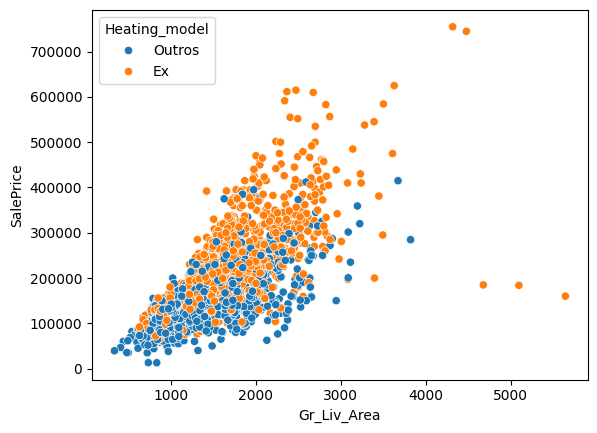

In [61]:
#plotando 
sns.scatterplot(data=precos1, x='Gr_Liv_Area', y='SalePrice', hue='Heating_model')
plt.show()

In [62]:
# criando as dummies
precos1_dummie = pd.get_dummies(precos1)
precos1_dummie.head()

,SalePrice,Basement_Area,Lot_Area,Season_Sold,Gr_Liv_Area,Garage_Area,Deck_Porch_Area,Age_Sold,Bedroom_AbvGr,Total_Bathroom,Heating_QC_Ex,Heating_QC_Fa,Heating_QC_Gd,Heating_QC_Po,Heating_QC_TA,Heating_Ex,Heating_Outros,Heating_TA,Heating_model_Ex,Heating_model_Outros
0,215000.0,1080.0,31770.0,2.0,1656.0,528.0,272.0,50.0,3.0,2.0,False,True,False,False,False,False,True,False,False,True
1,105000.0,882.0,11622.0,3.0,896.0,730.0,260.0,49.0,2.0,1.0,False,False,False,False,True,False,False,True,False,True
2,172000.0,1329.0,14267.0,3.0,1329.0,312.0,429.0,52.0,3.0,1.1,False,False,False,False,True,False,False,True,False,True
3,244000.0,2110.0,11160.0,2.0,2110.0,522.0,0.0,42.0,3.0,3.1,True,False,False,False,False,True,False,False,True,False
4,189900.0,928.0,13830.0,2.0,1629.0,482.0,246.0,13.0,3.0,2.1,False,False,True,False,False,False,True,False,False,True


In [63]:
# criando o modelo
# Criando o objeto X com a variável independentes (somente as dummies, já tirando uma delas + a variável numérica)
# como as dummies eram booleanas utilizei o astype para transformar em 0 e 1
X = precos1_dummie[['Heating_model_Ex', 'Gr_Liv_Area']]
X[['Heating_model_Ex']] = X[['Heating_model_Ex']].astype(int)
# criando o objeto y com a variável resposta
y = precos1_dummie["SalePrice"]
# Aqui lembre-se do B0. Basicamente vamos adicionar uma coluna de 1s para que o B0 seja calculado.
X = sm.add_constant(X)
# Ajustando o modelo
modelo_dummie_num3 = sm.OLS(y, X).fit()
# Resumo do modelo
print(modelo_dummie_num3.summary())
# gerando o ychapeu a partir desse modelo
pred3 = modelo_dummie_num3.predict(X)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.570
Model:                            OLS   Adj. R-squared:                  0.570
Method:                 Least Squares   F-statistic:                     1940.
Date:                Tue, 21 Jan 2025   Prob (F-statistic):               0.00
Time:                        13:42:11   Log-Likelihood:                -35971.
No. Observations:                2928   AIC:                         7.195e+04
Df Residuals:                    2925   BIC:                         7.197e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             9289.1744   3037.770  

C:\Users\mattr\AppData\Local\Temp\ipykernel_6324\2878683465.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['Heating_model_Ex']] = X[['Heating_model_Ex']].astype(int)


In [64]:
#criando o ychapeu para poder criar o gráfico
precos1_dummie['ychapeu_dummies'] = modelo_dummie_num3.predict(X)
precos1_dummie['ychapeu_heating_ex'] =  9289.174 + 44250.788*1 + 99.330*precos1_dummie['Gr_Liv_Area']
precos1_dummie['ychapeu_heating_outros'] =  9289.174 + 44250.788*0 + 99.330*precos1_dummie['Gr_Liv_Area']
precos1_dummie['Heating_model'] = precos1['Heating_model']

### <code style="color:green"> Visualizando o conceito de se trabalhar com uma X categórica e outra numérica</code>

- Criado o modelo, agora vamos analisar as predições sobre cada uma das dummies, visualizando no gráfico de dispersão


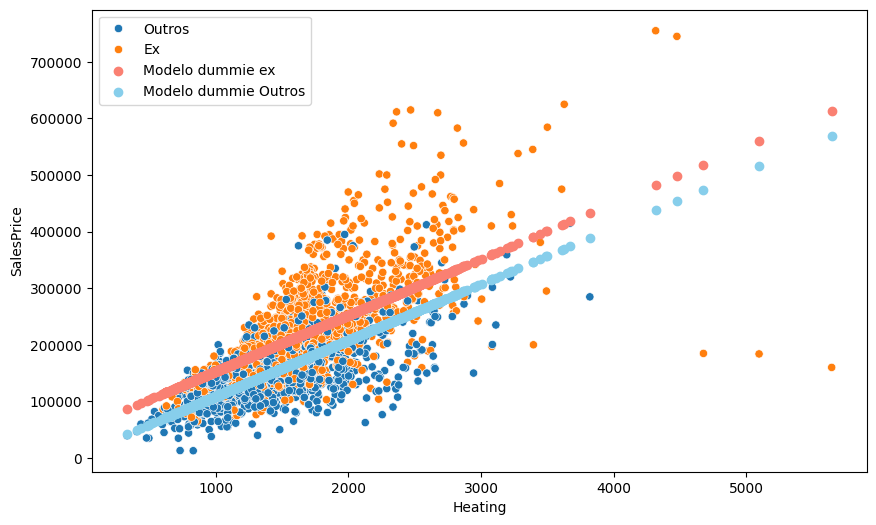

In [65]:
# definindo o tamanho da área do gráfico
plt.figure(figsize=(10, 6))
# plotando x e y, pintando confome a variável categórica
sns.scatterplot(data=precos1_dummie, x='Gr_Liv_Area', y='SalePrice', hue='Heating_model')
# desenhando a reta para quando Heating é Ex
plt.scatter(precos1_dummie["Gr_Liv_Area"], precos1_dummie["ychapeu_heating_ex"], color='salmon', label='Modelo dummie ex')
# desenhando a reta para quando Heating é Outros
plt.scatter(precos1_dummie["Gr_Liv_Area"], precos1_dummie["ychapeu_heating_outros"], color='skyblue', label='Modelo dummie Outros')

plt.xlabel('Heating')
plt.ylabel('SalesPrice')
plt.legend()
plt.show()


### <code style="color:purple">COMENTÁRIOS:</code>

- Reparem que as retas ficam paralelas (porque só muda o $\beta_{0}$). Ou seja, notamos que vale a pena fazer "um modelo para cada" quando existe diferença nas médias de Y conforme o nível da variável X categórica muda. Caso contrário, não há necessidade de colocar duas retas (que passariam pelo mesmo lugar).

### <code style="color:green">Análise de Residuo</code>


Para fechar essa discussão, vamos fazer a análise de resíduo do modelo gerado

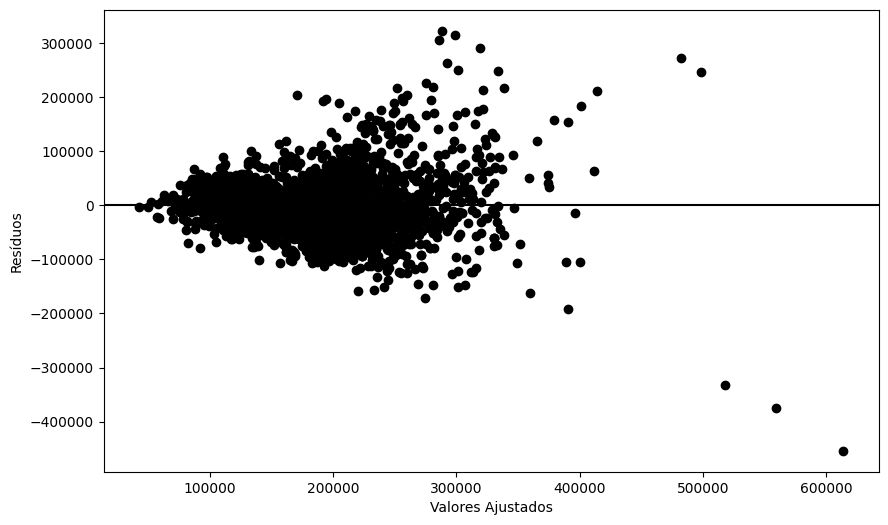

In [66]:
# plotando o ajustado X residuo 
# criando o valor predito
chute_modelo_dummie_num3 = modelo_dummie_num3.predict(X)

plt.figure(figsize=(10, 6))
#fazendo o gráfico de predito x resíduo
plt.scatter(chute_modelo_dummie_num3,modelo_dummie_num3.resid, color='black')
plt.axhline(y=0, color = 'black')
plt.xlabel('Valores Ajustados')
plt.ylabel('Resíduos')
plt.show()

### <code style="color:purple">COMENTÁRIOS:</code>

-  Veja que temos um padrão de aglomeração, ou seja, não são independentes.
- É visivel a boca de jacaré, ou seja, heterocedasticidade.